# Chapter 9: Debugging a PyTorch Image Classifier

## <font color=green>**Adversarial Example Attacks.**</font>

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import ConcatDataset, DataLoader, Dataset
from torchvision import datasets, transforms
from torchvision.datasets import ImageFolder

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
random_seed = 12345

PATH = "chest_xray_pre-processed"

In [2]:
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    numpy.random.seed(worker_seed)
    random.seed(worker_seed)


g = torch.Generator()
g.manual_seed(0)

In [3]:
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

classes = dict({0: "NORMAL", 1: "PNEUMONIA"})

In [4]:
MEAN = torch.tensor([0.485, 0.456, 0.406])
STD = torch.tensor([0.229, 0.224, 0.225])


from matplotlib.colors import LinearSegmentedColormap


def imshow(img, transpose=True):
    plt.figure(figsize=(11, 6))
    x = img.cpu() * STD[:, None, None] + MEAN[:, None, None]
    # x = img.cpu()
    # x= x / 2 + 0.5     # unnormalize
    npimg = x.cpu().detach().numpy()
    plt.imshow(npimg.transpose(1, 2, 0))
    plt.axis("off")
    plt.show()

In [11]:
epsilons = [0, .02, 0.05, .1, .15, .2,]
pretrained_model = "model/Finetuning_Stage2.pt"
model = torch.load(pretrained_model, map_location=device)
model.eval();

In [12]:
testset = ImageFolder(
    PATH + "/test",
    transform=transforms.Compose(
        [
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ]
    ),
)
test_dl = DataLoader(testset, batch_size=1)

In [13]:
# FGSM attack code
# Code adapted from https://pytorch.org/tutorials/beginner/fgsm_tutorial.html
def fgsm_attack(image, epsilon, data_grad):
    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign()
    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image + epsilon * sign_data_grad
    # Adding clipping to maintain [0,1] range
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    # Return the perturbed image
    return perturbed_image

In [14]:
# Code adapted from https://pytorch.org/tutorials/beginner/fgsm_tutorial.html
def test(model, device, test_loader, epsilon):

    # Performance counter
    correct = 0
    adv_examples = []

    # Loop over all examples in test set
    for data, target in test_loader:

        # Send the data and label to the device
        data, target = data.to(device), target.to(device)

        # Set requires_grad attribute of tensor. Important for Attack
        data.requires_grad = True

        # Forward pass the data through the model
        output = model(data)
        init_pred = output.max(1, keepdim=True)[
            1
        ]  # get the index of the max log-probability

        # If the initial prediction is wrong, dont bother attacking, just move on
        if init_pred.item() != target.item():
            continue

        # Calculate the loss
        loss = F.nll_loss(output, target)

        # Zero all existing gradients
        model.zero_grad()

        # Calculate gradients of model in backward pass
        loss.backward()

        # Collect datagrad
        data_grad = data.grad.data

        # Call FGSM Attack
        perturbed_data = fgsm_attack(data, epsilon, data_grad)

        # Re-classify the perturbed image
        output = model(perturbed_data)

        # Check for success
        final_pred = output.max(1, keepdim=True)[1]  # get the index of the max log-probability
        if final_pred.item() == target.item():
            correct += 1
            # Special case for saving 0 epsilon examples
            if (epsilon == 0) and (len(adv_examples) < 5):
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append((init_pred.item(), final_pred.item(), adv_ex))
        else:
            # Save some adv examples for visualization later
            if len(adv_examples) < 5:
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append((init_pred.item(), final_pred.item(), adv_ex))

    # Calculate final accuracy for this epsilon
    final_acc = correct / float(len(test_loader))
    print(
        "Epsilon: {}\tTest Accuracy = {} / {} = {}".format(
            epsilon, correct, len(test_loader), final_acc
        )
    )

    # Return the accuracy and an adversarial example
    return final_acc, adv_examples

In [15]:
accuracies = []
examples = []

# Run test for each epsilon
for eps in epsilons:
    acc, ex = test(model, device, test_dl, eps)
    accuracies.append(acc)
    examples.append(ex)

/Users/parul/miniconda3/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ../c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Epsilon: 0	Test Accuracy = 519 / 624 = 0.8317307692307693
Epsilon: 0.02	Test Accuracy = 285 / 624 = 0.4567307692307692
Epsilon: 0.05	Test Accuracy = 160 / 624 = 0.2564102564102564
Epsilon: 0.1	Test Accuracy = 133 / 624 = 0.21314102564102563
Epsilon: 0.15	Test Accuracy = 155 / 624 = 0.2483974358974359
Epsilon: 0.2	Test Accuracy = 177 / 624 = 0.28365384615384615


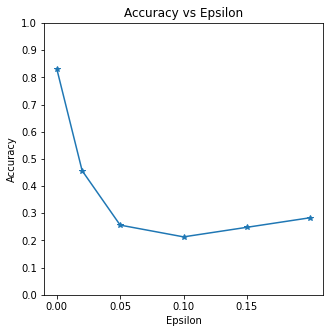

In [19]:
plt.figure(figsize=(5, 5))
plt.plot(epsilons, accuracies, "*-")
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(np.arange(0, 0.20, step=0.05))
plt.title("Accuracy vs Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.savefig('ff.svg')
plt.show()